# Unprojecting pupils

Example to fit pupils and unproject.

This is the slow version.

## Load data

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import flexiznam as flz
from skimage.measure import EllipseModel
import cv2

raw = Path(flz.PARAMETERS["data_root"]["raw"])
processed = Path(flz.PARAMETERS["data_root"]["processed"])
project = "blota_onix_pilote"
mouse = "BRAC6692.4a"
session = "S20221125"
recording = "R154923"
camera = "eye_camera"

fname = "eye_camera_2022-11-25T15_49_23_cropped"
data_path = processed / project / mouse / session / recording / camera
dlc_path = data_path / "dlc_output"

In [10]:
from cottage_analysis.eye_tracking import eye_model_fitting as emf

ellipse_fits = None
print("Fitting ellipses")
for fname in dlc_path.glob("*.h5"):
    if "filtered" in fname.name:
        continue
    if ellipse_fits is not None:
        raise IOError("Multiple DLC results files")

    fit_save = dlc_path / "{0}_ellipse_fit.csv".format(fname.stem)
    if fit_save.exists():
        ellipse_fits = pd.read_csv(fit_save)
    else:
        ellipse_fits = emf.fit_ellipses(fname)
        ellipse_fits.to_csv(fit_save, index=False)

Fitting ellipses


## Slow fit

First select one frame to work with

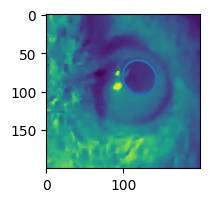

In [80]:
frame_id = 14003

ellipse = ellipse_fits.loc[frame_id]
elmod = EllipseModel()
elmod.params = (
    ellipse.centre_x,
    ellipse.centre_y,
    ellipse.major_radius,
    ellipse.minor_radius,
    ellipse.angle,
)
video_file = data_path / "{0}.mp4".format(fname)
cam_data = cv2.VideoCapture(str(video_file))
cam_data.set(cv2.CAP_PROP_POS_FRAMES, frame_id - 1)
ret, frame = cam_data.read()
img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cam_data.release()

circ_coord = elmod.predict_xy(np.arange(0, 2 * np.pi, 0.1))

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
ax.plot(circ_coord[:, 0], circ_coord[:, 1])

## Find cone



In [213]:
ellipse

centre_x        120.892347
centre_y         81.838014
angle             1.005329
major_radius     23.512215
minor_radius     21.096605
Name: 14003, dtype: float64

Unprojecting


Text(0.5, 0, 'Z')

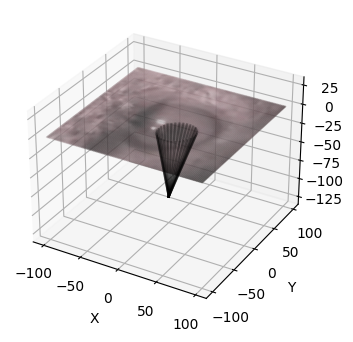

In [216]:
# let's unproject
print("Unprojecting")
px_per_mm = 10
focal_length = 10.0 * px_per_mm

cam_centre_in_ellipse = np.array([0, 0, -focal_length])
centred_ellipse = ellipse.copy()
centred_ellipse["centre_x"] -= 100
centred_ellipse["centre_y"] -= 100
cone_base = emf.conic(centred_ellipse)
pupil_cone = emf.conicoid(cone_base, cam_centre_in_ellipse)
a, b, c, d, f, g, h, u, v, w = pupil_cone


# plot
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1, projection="3d")
X, Y = np.meshgrid(np.arange(frame.shape[1]) - 100, np.arange(frame.shape[0]) - 100)
ax.plot_surface(
    X,
    Y,
    np.zeros_like(X),
    facecolors=frame / frame.max(),
    rstride=1,
    cstride=2,
    alpha=0.2,
    zorder=-10,
)
for el in circ_coord[::2]:
    ax.plot(
        [el[0] - 100, cam_centre_in_ellipse[0]],
        [el[1] - 100, cam_centre_in_ellipse[1]],
        [0, cam_centre_in_ellipse[2]],
        color="k",
        alpha=0.3,
        zorder=10,
    )
ax.set_aspect("equal")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# ax.view_init(elev=60, azim=60, roll=0)

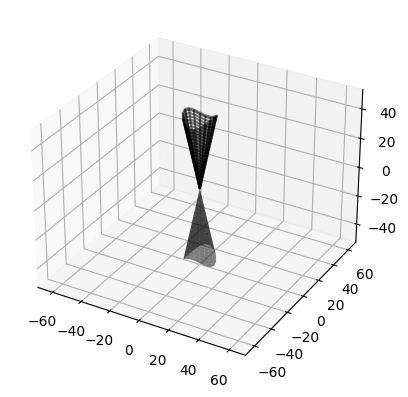

In [217]:
# Get canonical conic form:
#     lambda(1) X^2 + lambda(2) Y^2 + lambda(3) Z^2 = mu
# Safaee-Rad 1992 eq (6)
# Done by solving the discriminating cubic (10)
# Lambdas are sorted descending because order of roots doesn't
# matter, and it later eliminates the case of eq (30), where
# lambda(2) > lambda(1)

cubic = emf.Polynomial(
    [
        -(a * b * c + 2 * f * g * h - a * f**2 - b * g**2 - c * h**2),
        (b * c + c * a + a * b - f**2 - g**2 - h**2),
        -(a + b + c),
        1.0,
    ],
)
lambdas = np.sort(cubic.roots())[::-1]

assert lambdas[0] >= lambdas[1]
assert lambdas[1] > 0
assert lambdas[2] < 0


# plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
r = np.linspace(0, np.pi, 10)
el = np.linspace(-10, 10, 100)
T, R = np.meshgrid(r, el)

# Then calculate X, Y, and Z
X = R * np.cos(T)
Y = R * np.sin(T)
Z = np.sqrt((-lambdas[0] * X**2 - lambdas[1] * Y**2) / lambdas[2])
ax.plot_wireframe(X, Y, Z, color="k", alpha=0.5)
ax.plot_surface(X, Y, -Z, color="k", alpha=0.5)
ax.set_aspect("equal")

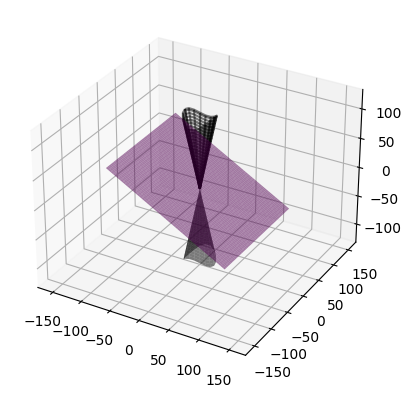

In [218]:
# Now want to calculate l,m,n of the plane
#     lX + mY + nZ = p
# which intersects the cone to create a circle.
# Safaee-Rad 1992 eq (31)
# [Safaee-Rad 1992 eq (33) comes out of this as a result of lambdas[1] == lambdas[2]]
n = np.sqrt((lambdas[1] - lambdas[2]) / (lambdas[0] - lambdas[2]))
m = 0.0
l = np.sqrt((lambdas[0] - lambdas[1]) / (lambdas[0] - lambdas[2]))


# plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
r = np.linspace(0, np.pi, 10)
el = np.linspace(-25, 25, 100)
T, R = np.meshgrid(r, el)

# Then calculate X, Y, and Z
X = R * np.cos(T)
Y = R * np.sin(T)
Z = np.sqrt((-lambdas[0] * X**2 - lambdas[1] * Y**2) / lambdas[2])
ax.plot_wireframe(X, Y, Z, color="k", alpha=0.5)
ax.plot_surface(X, Y, -Z, color="k", alpha=0.5)
ax.set_aspect("equal")

# add the plane
X, Y = np.meshgrid(*[np.arange(-100, 100)] * 2)
Z = (-l * X - m * Y) / n
ax.plot_surface(X, Y, Z, color="purple", alpha=0.5)

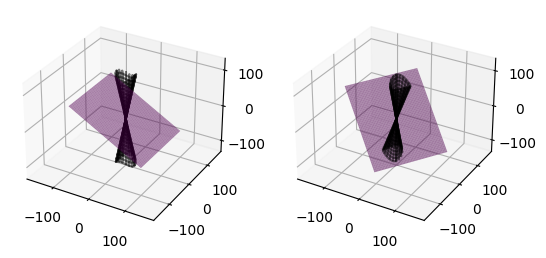

In [219]:
# Want to calculate T1, the rotation transformation from image
# space in the canonical conic frame back to image space in the
# real world

# Safaee-Rad 1992 eq (12)
t1 = (b - lambdas) * g - f * h
t2 = (a - lambdas) * f - g * h
t3 = -(a - lambdas) * (t1 / t2) / g - h / g

mi = 1 / np.sqrt(1 + (t1 / t2) ** 2 + t3**2)
li = (t1 / t2) * mi
ni = t3 * mi

# Safaee-Rad 1992 eq (8)
T1 = np.identity(4)
T1[:3, :3] = np.vstack([li, mi, ni])

# If li,mi,ni follow the left hand rule, flip their signs
if np.dot(np.cross(li, mi), ni) < 0:
    li = -li
    mi = -mi
    ni = -ni

# plot
fig = plt.figure()
for i in range(2):
    ax = fig.add_subplot(1, 2, 1 + i, projection="3d")
    r = np.linspace(0, np.pi, 10)
    el = np.linspace(-25, 25, 100)
    T, R = np.meshgrid(r, el)

    # Then calculate X, Y, and Z
    X = R * np.cos(T)
    Y = R * np.sin(T)
    Z = np.sqrt((-lambdas[0] * X**2 - lambdas[1] * Y**2) / lambdas[2])
    X = np.vstack([X, X])
    Y = np.vstack([Y, Y])
    Z = np.vstack([Z, -Z])

    if i:
        xyzo = np.hstack(
            [v.reshape(-1, 1) for v in [X, Y, Z, np.ones_like(Z)]]
        ).reshape((-1, 4, 1))
        xyzo = T1.reshape((1, 4, 4)) @ xyzo
        X = xyzo[:, 0, 0].reshape(X.shape)
        Y = xyzo[:, 1, 0].reshape(Y.shape)
        Z = xyzo[:, 2, 0].reshape(Z.shape)

    ax.plot_wireframe(X, Y, Z, color="k", alpha=0.5)

    ax.set_aspect("equal")

    # add the plane
    X, Y = np.meshgrid(*[np.arange(-100, 100)] * 2)
    Z = (-l * X - m * Y) / n
    if i:
        xyzo = np.hstack(
            [v.reshape(-1, 1) for v in [X, Y, Z, np.ones_like(Z)]]
        ).reshape((-1, 4, 1))
        xyzo = T1.reshape((1, 4, 4)) @ xyzo
        X = xyzo[:, 0, 0].reshape(X.shape)
        Y = xyzo[:, 1, 0].reshape(Y.shape)
        Z = xyzo[:, 2, 0].reshape(Z.shape)

    ax.plot_surface(X, Y, Z, color="purple", alpha=0.5)

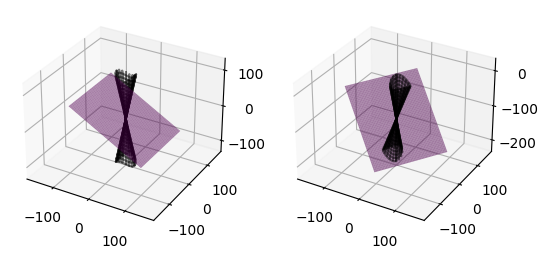

In [220]:
# Calculate T2, a translation transformation from the canonical
# conic frame to the image space in the canonical conic frame
# Safaee-Rad 1992 eq (14)
T2 = np.identity(4)
T2[:3, 3] = -(u * li + v * mi + w * ni) / lambdas

# plot
fig = plt.figure()
for i in range(2):
    ax = fig.add_subplot(1, 2, 1 + i, projection="3d")
    r = np.linspace(0, np.pi, 10)
    el = np.linspace(-25, 25, 100)
    T, R = np.meshgrid(r, el)

    # Then calculate X, Y, and Z
    X = R * np.cos(T)
    Y = R * np.sin(T)
    Z = np.sqrt((-lambdas[0] * X**2 - lambdas[1] * Y**2) / lambdas[2])
    X = np.vstack([X, X])
    Y = np.vstack([Y, Y])
    Z = np.vstack([Z, -Z])

    if i:
        xyzo = np.hstack(
            [v.reshape(-1, 1) for v in [X, Y, Z, np.ones_like(Z)]]
        ).reshape((-1, 4, 1))
        xyzo = T1.reshape((1, 4, 4)) @ T2.reshape((1, 4, 4)) @ xyzo
        X = xyzo[:, 0, 0].reshape(X.shape)
        Y = xyzo[:, 1, 0].reshape(Y.shape)
        Z = xyzo[:, 2, 0].reshape(Z.shape)

    ax.plot_wireframe(X, Y, Z, color="k", alpha=0.5)

    ax.set_aspect("equal")

    # add the plane
    X, Y = np.meshgrid(*[np.arange(-100, 100)] * 2)
    Z = (-l * X - m * Y) / n
    if i:
        xyzo = np.hstack(
            [v.reshape(-1, 1) for v in [X, Y, Z, np.ones_like(Z)]]
        ).reshape((-1, 4, 1))
        xyzo = T1.reshape((1, 4, 4)) @ T2.reshape((1, 4, 4)) @ xyzo
        X = xyzo[:, 0, 0].reshape(X.shape)
        Y = xyzo[:, 1, 0].reshape(Y.shape)
        Z = xyzo[:, 2, 0].reshape(Z.shape)

    ax.plot_surface(X, Y, Z, color="purple", alpha=0.5)

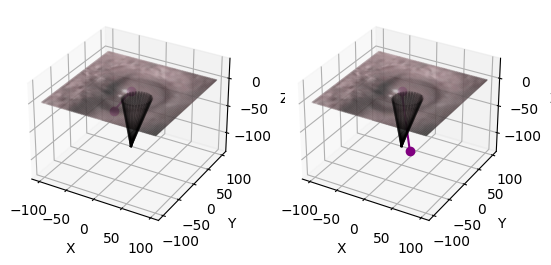

In [233]:
circle_radius = 30 * px_per_mm
ls = [l, -l]
solutions = []
fig = plt.figure()

for i, l in enumerate(ls):
    # Circle normal in image space (i.e. gaze vector)
    gaze = T1 @ np.array([l, m, n, 1])

    # plot
    ax = fig.add_subplot(1, 2, 1 + i, projection="3d")
    X, Y = np.meshgrid(np.arange(frame.shape[1]) - 100, np.arange(frame.shape[0]) - 100)
    ax.plot_surface(
        X,
        Y,
        np.zeros_like(X),
        facecolors=frame / frame.max(),
        rstride=1,
        cstride=3,
        alpha=0.2,
        zorder=-10,
    )
    for el in circ_coord[::2]:
        ax.plot(
            [el[0] - 100, cam_centre_in_ellipse[0]],
            [el[1] - 100, cam_centre_in_ellipse[1]],
            [0, cam_centre_in_ellipse[2]],
            color="k",
            alpha=0.3,
            zorder=10,
        )
    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.plot(
        [0, gaze[0] * 100],
        [0, gaze[1] * 100],
        [0, gaze[2] * 100],
        marker="o",
        color="purple",
    )

In [ ]:
for i, l in enumerate(ls):
    # Calculate T3, a rotation from a frame where Z is the circle normal
    # to the canonical conic frame
    # Safaee-Rad 1992 eq (19)
    # Want T3 = / -m/sqrt(l*l+m*m) -l*n/sqrt(l*l+m*m) l \
    #              |  l/sqrt(l*l+m*m) -m*n/sqrt(l*l+m*m) m |
    #                \            0           sqrt(l*l+m*m)   n /
    # But m = 0, so this simplifies to
    #      T3 = /       0      -n*l/sqrt(l*l) l \
    #           |  l/sqrt(l*l)        0       0 |
    #           \          0         sqrt(l*l)   n /
    #         = /    0    -n*sgn(l) l \
    #           |  sgn(l)     0     0 |
    #           \       0       |l|    n /

    if l == 0:
        # Discontinuity of sgn(l), have to handle explicitly
        assert n == 1
        print("Warning: l == 0")
        T3 = np.array([[0, -1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    else:
        sgnl = np.sign(l)
        T3 = np.array(
            [
                [0, -n * np.sign(l), l, 0],
                [np.sign(l), 0, 0, 0],
                [0, abs(l), n, 0],
                [0, 0, 0, 1],
            ]
        )

    # Calculate the circle centre
    # Safaee-Rad 1992 eq (38), using T3 as defined in (36)
    A = lambdas @ T3[:3, 0] ** 2
    B = lambdas @ (T3[:3, 0] * T3[:3, 2])
    C = lambdas @ (T3[:3, 1] * T3[:3, 2])
    D = lambdas @ T3[:3, 2] ** 2

    # Safaee-Rad 1992 eq (41)
    Z0 = A * circle_radius / np.sqrt(B**2 + C**2 - A * D)
    X0 = -B / A * Z0
    Y0 = -C / A * Z0
    centre_in_Xprime = np.array([X0, Y0, Z0, 1])

    # Safaee-Rad 1992 eq (34)
    T0 = np.identity(4)
    T0[2, 3] = focal_length

    # Safaee-Rad 1992 eq (42) using (35)
    centre = T0 @ T1 @ T2 @ T3 @ centre_in_Xprime

    # If z is negative (behind the camera), choose the other
    # solution of eq (41) [maybe there's a way of calculating which
    # solution should be chosen first]

    if centre[2] < 0:
        centre_in_Xprime = -centre_in_Xprime
        centre = T0 @ T1 @ T2 @ T3 @ centre_in_Xprime

    # Make sure that the gaze vector is toward the camera and is normalised
    if np.dot(gaze, centre) > 0:
        gaze[:3] = -gaze[:3]

    gaze /= np.linalg.norm(gaze[:3])

    # Save the results
    solutions.append(dict(centre=centre, gaze=gaze, circle_radius=circle_radius))

    ax = fig.add_subplot(1, 2, 1 + i, projection="3d")
    r = np.linspace(0, np.pi, 10)
    el = np.linspace(-300, 300, 100)
    T, R = np.meshgrid(r, el)

    # Then calculate X, Y, and Z
    X = R * np.cos(T)
    Y = R * np.sin(T)
    Z = np.sqrt((-lambdas[0] * X**2 - lambdas[1] * Y**2) / lambdas[2])
    X = np.vstack([X, X])
    Y = np.vstack([Y, Y])
    Z = np.vstack([Z, -Z])

    xyzo = np.hstack([v.reshape(-1, 1) for v in [X, Y, Z, np.ones_like(Z)]]).reshape(
        (-1, 4, 1)
    )
    xyzo = (T0 @ T1 @ T2 @ T3).reshape((1, 4, 4)) @ xyzo
    X = xyzo[:, 0, 0].reshape(X.shape)
    Y = xyzo[:, 1, 0].reshape(Y.shape)
    Z = xyzo[:, 2, 0].reshape(Z.shape)

    ax.plot_wireframe(X, Y, Z, color="k", alpha=0.5)

    ax.set_aspect("equal")

    # add the plane
    X, Y = np.meshgrid(*[np.arange(-100, 100)] * 2)
    Z = (-l * X - m * Y) / n

    xyzo = np.hstack([v.reshape(-1, 1) for v in [X, Y, Z, np.ones_like(Z)]]).reshape(
        (-1, 4, 1)
    )
    xyzo = (T0 @ T1 @ T2 @ T3).reshape((1, 4, 4)) @ xyzo
    X = xyzo[:, 0, 0].reshape(X.shape)
    Y = xyzo[:, 1, 0].reshape(Y.shape)
    Z = xyzo[:, 2, 0].reshape(Z.shape)

    ax.plot_surface(X, Y, Z, color="purple", alpha=0.5)

    ax.plot(*centre[:3], marker="o", color="r")
    print(centre)

In [170]:
v = xyzo[0]
print(v)
print(T1 @ v)

[  -4.70374632    7.77298574 -129.26056163    1.        ]
[ 33.26921526 -17.92120561 123.94687183   1.        ]
